In [976]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [966]:
def load_facts(filename):
    facts=[]
    for line in open(filename):
        line=line.strip().split(',')
        fact=[]
        if line[0]=='not':
            fact.append(True)
            line=line[1:]
        else:
            fact.append(False)
        fact.append(line[0])
        fact.append(line[1:])
        facts.append(fact)
    return facts
        

In [1091]:
emb_dim=100

In [1136]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN, self).__init__()
        self.emb_dim=emb_dim
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.pos_embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
        self.predicate_params=dict()
        for symbol,n in predicates:
            params=[]
            m=n*self.emb_dim
            params.append(m)
            params.append(Variable(torch.randn(m, self.emb_dim, m), requires_grad=True))
            params.append(Variable(torch.randn(m, self.emb_dim), requires_grad=True))
            params.append(Variable(torch.randn(self.emb_dim), requires_grad=True))
            params.append(Variable(torch.randn(self.emb_dim), requires_grad=True))
            self.predicate_params[symbol]=params
    def forward(self, predicats):
        predicate_results=[]
        Ans=None
        for i,p in enumerate(predicats):
            negations=p[0]
            P=p[1]
            constants=p[2]
            constant_id=[]
            for c in constants:
                constant_id.append(self.symbol2id[c])
            embs=self.pos_embeddings(Variable(torch.LongTensor(constant_id)))
            embs=torch.cat(embs).view(1,-1)
            m,W,V,B,u=self.predicate_params[P]
            W=W.view(m,-1)
            output=torch.mm(embs,W)
            output=output.view(-1,m)
            output=torch.mm(output,embs.view(-1,1))
            output=output.view(1,-1)
            output=output.add(torch.mm(embs,V))
            output=output.add(B)
            output=output.view(-1)
            output=torch.tanh(output)
            output=torch.mul(output,u).sum()
            output=torch.sigmoid(output)
            if negations:
                output=1.0-output
            predicate_results.append(output)
            if Ans is None or Ans.data.numpy()[0]<output.data.numpy()[0]:
                Ans=output
#         predicate_results=Variable(torch.FloatTensor(predicate_results))
#         return predicate_results[0]
        return torch.log(Ans),Ans

In [1152]:
facts1=load_facts('./facts1.txt')
facts2=load_facts('./facts2.txt')
facts=facts1+facts2
ltn=LTN(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
ltn.forward(predicats=facts[0:1])

(Variable containing:
 -0.4608
 [torch.FloatTensor of size 1], Variable containing:
  0.6308
 [torch.FloatTensor of size 1])

100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


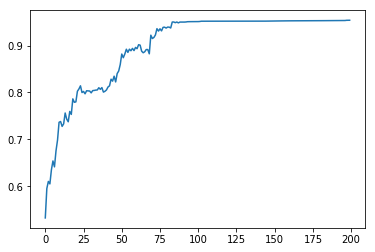

In [1153]:
optimizor=torch.optim.Adam(ltn.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
errs=[]
for i in tqdm(range(200)):
    optimizor.zero_grad()
    total_probability=0
    for f in facts:
        log,prob=ltn.forward(predicats=[f])
        prob.backward(mone)
        total_probability+=prob.data.numpy()[0]
    optimizor.step()
    errs.append(total_probability/len(facts))
plt.plot(errs)
plt.show()

In [1154]:
def show_results(facts):
    for f in facts:
        output=ltn.forward(predicats=[f])
        if output[1].data.numpy()[0]>0.9:
            continue
        print(f)
        print(output[1].data.numpy()[0])

In [1155]:
show_results(facts)

[False, 'S', ['g']]
0.683382
[True, 'S', ['g']]
0.316618
[False, 'F', ['a', 'g']]
0.0558051
[True, 'C', ['g']]
0.0
